<a href="https://colab.research.google.com/github/himanshu-mishra-data/Pharma_Sales_ML_Pipeline.ipynb/blob/main/Pharma_Sales_ML_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generated 2000 sales records.
--- ETL: Loading Data into SQL Database ---
Top 5 Rows of Aggregated SQL Data:
     Month     Category  Monthly_Revenue  Avg_Units_Sold
0  2023-01   Analgesics         43923.21       26.250000
1  2023-01  Antibiotics         62809.05       45.750000
2  2023-01  Antiseptics        161720.37       58.555556
3  2023-01   Antivirals         54074.17       45.250000
4  2023-01     Vitamins        170847.83       65.363636

--- ML: Training Random Forest Regressor ---
Model Performance:
Mean Absolute Error: $9594.10
R2 Score: -0.17


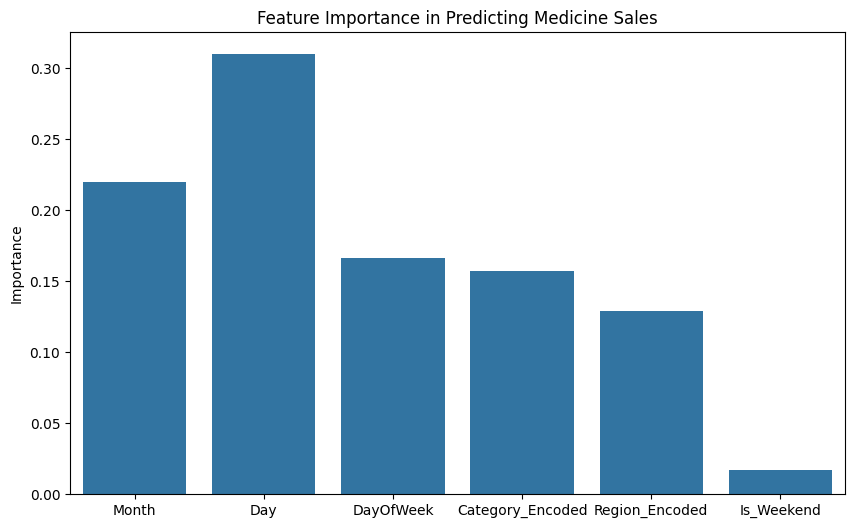


--- Conclusion ---
Project ran successfully. Use the 'monthly_stats' dataframe for reporting and 'rf_model' for predictions.


In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
import datetime

# ==========================================
# PART 1: DATA GENERATION (Mocking a Real DB)
# ==========================================
def generate_dummy_data(num_records=1000):
    np.random.seed(42)

    # Setup data parameters
    dates = pd.date_range(start='2023-01-01', periods=num_records, freq='D')
    drug_categories = ['Antibiotics', 'Analgesics', 'Antivirals', 'Antiseptics', 'Vitamins']
    regions = ['North', 'South', 'East', 'West']

    data = {
        'Date': np.random.choice(dates, num_records),
        'Drug_ID': np.random.randint(1001, 1050, num_records),
        'Category': np.random.choice(drug_categories, num_records),
        'Region': np.random.choice(regions, num_records),
        'Quantity_Sold': np.random.randint(1, 100, num_records),
        'Unit_Price': np.round(np.random.uniform(10, 500, num_records), 2),
        'Is_Weekend': [0] * num_records # Placeholder to be filled later
    }

    df = pd.DataFrame(data)

    # Add some logical patterns (e.g., higher sales on weekends for some items)
    df['Day_Name'] = df['Date'].dt.day_name()
    df['Is_Weekend'] = df['Day_Name'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
    df['Total_Sales'] = df['Quantity_Sold'] * df['Unit_Price']

    return df

# ==========================================
# PART 2: SQL PIPELINE (ETL)
# ==========================================
def load_and_query_sql(df):
    print("--- ETL: Loading Data into SQL Database ---")
    # Create in-memory SQLite DB
    conn = sqlite3.connect(':memory:')
    df.to_sql('sales_records', conn, index=False, if_exists='replace')

    # SIMULATING A DATA ANALYST TASK:
    # Extract aggregated monthly sales via SQL instead of Pandas (resume skill: SQL Connection)
    query = """
    SELECT
        strftime('%Y-%m', Date) as Month,
        Category,
        SUM(Total_Sales) as Monthly_Revenue,
        AVG(Quantity_Sold) as Avg_Units_Sold
    FROM sales_records
    GROUP BY Month, Category
    ORDER BY Month ASC
    """

    agg_df = pd.read_sql_query(query, conn)
    conn.close()
    return agg_df, df

# ==========================================
# PART 3: MACHINE LEARNING (Sales Forecasting)
# ==========================================
def train_sales_forecasting_model(df):
    print("\n--- ML: Training Random Forest Regressor ---")

    # Feature Engineering
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    # Encode Categorical Variables
    le_cat = LabelEncoder()
    df['Category_Encoded'] = le_cat.fit_transform(df['Category'])

    le_reg = LabelEncoder()
    df['Region_Encoded'] = le_reg.fit_transform(df['Region'])

    # Define Features (X) and Target (y)
    # Predicting 'Total_Sales' based on time, category, and region
    features = ['Month', 'Day', 'DayOfWeek', 'Category_Encoded', 'Region_Encoded', 'Is_Weekend']
    target = 'Total_Sales'

    X = df[features]
    y = df[target]

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Model Training
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions & Evaluation
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Model Performance:\nMean Absolute Error: ${mae:.2f}\nR2 Score: {r2:.2f}")

    # Feature Importance Visualization
    plt.figure(figsize=(10, 6))
    importances = model.feature_importances_
    sns.barplot(x=features, y=importances)
    plt.title('Feature Importance in Predicting Medicine Sales')
    plt.ylabel('Importance')
    plt.show()

    return model

# ==========================================
# MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    # 1. Generate Data
    raw_data = generate_dummy_data(2000)
    print(f"Generated {len(raw_data)} sales records.")

    # 2. ETL / SQL Analysis
    monthly_stats, full_data = load_and_query_sql(raw_data)
    print("Top 5 Rows of Aggregated SQL Data:")
    print(monthly_stats.head())

    # 3. Machine Learning
    rf_model = train_sales_forecasting_model(full_data)

    print("\n--- Conclusion ---")
    print("Project ran successfully. Use the 'monthly_stats' dataframe for reporting and 'rf_model' for predictions.")